In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 100

In [16]:
sessions = pd.read_csv('../data/raw/Dataset 1_EV charging reports.csv')
sessions.head()

,session_ID,Garage_ID,User_ID,User_type,Shared_ID,Start_plugin,Start_plugin_hour,End_plugout,End_plugout_hour,El_kWh,Duration_hours,month_plugin,weekdays_plugin,Plugin_category,Duration_category
0,1,AdO3,AdO3-4,Private,NaN,21.12.2018 10:20,10,21.12.2018 10:23,10.0,"0,3","0,05",Dec,Friday,late morning (9-12),Less than 3 hours
1,2,AdO3,AdO3-4,Private,NaN,21.12.2018 10:24,10,21.12.2018 10:32,10.0,"0,87","136,666,667",Dec,Friday,late morning (9-12),Less than 3 hours
2,3,AdO3,AdO3-4,Private,NaN,21.12.2018 11:33,11,21.12.2018 19:46,19.0,"29,87","8,216,388,889",Dec,Friday,late morning (9-12),Between 6 and 9 hours
3,4,AdO3,AdO3-2,Private,NaN,22.12.2018 16:15,16,23.12.2018 16:40,16.0,"15,56","2,441,972,222",Dec,Saturday,late afternoon (15-18),More than 18 hours
4,5,AdO3,AdO3-2,Private,NaN,24.12.2018 22:03,22,24.12.2018 23:02,23.0,"3,62","970,555,556",Dec,Monday,late evening (21-midnight),Less than 3 hours


## data processing

In [17]:
sessions['El_kWh'] = sessions['El_kWh'].str.replace(',', '.')
sessions['El_kWh'] = sessions['El_kWh'].astype('float')

sessions = sessions.dropna(subset=['Start_plugin', 'End_plugout'])

sessions['Start_plugin'] = pd.to_datetime(sessions['Start_plugin'], format='%d.%m.%Y %H:%M')
sessions['End_plugout'] = pd.to_datetime(sessions['End_plugout'], format='%d.%m.%Y %H:%M')
sessions['Duration_hours'] = (sessions['End_plugout'] - sessions['Start_plugin']) / pd.Timedelta(hours=1)

In [4]:
# remaining 6844 charging sessions

print(sessions.shape)
sessions.head()

(6844, 15)


,session_ID,Garage_ID,User_ID,User_type,Shared_ID,Start_plugin,Start_plugin_hour,End_plugout,End_plugout_hour,El_kWh,Duration_hours,month_plugin,weekdays_plugin,Plugin_category,Duration_category
0,1,AdO3,AdO3-4,Private,NaN,2018-12-21 10:20:00,10,2018-12-21 10:23:00,10.0,0.30,0.050000,Dec,Friday,late morning (9-12),Less than 3 hours
1,2,AdO3,AdO3-4,Private,NaN,2018-12-21 10:24:00,10,2018-12-21 10:32:00,10.0,0.87,0.133333,Dec,Friday,late morning (9-12),Less than 3 hours
2,3,AdO3,AdO3-4,Private,NaN,2018-12-21 11:33:00,11,2018-12-21 19:46:00,19.0,29.87,8.216667,Dec,Friday,late morning (9-12),Between 6 and 9 hours
3,4,AdO3,AdO3-2,Private,NaN,2018-12-22 16:15:00,16,2018-12-23 16:40:00,16.0,15.56,24.416667,Dec,Saturday,late afternoon (15-18),More than 18 hours
4,5,AdO3,AdO3-2,Private,NaN,2018-12-24 22:03:00,22,2018-12-24 23:02:00,23.0,3.62,0.983333,Dec,Monday,late evening (21-midnight),Less than 3 hours


In [5]:
# drop some columns

sessions = sessions.drop(columns=['session_ID', 'Start_plugin_hour', 'End_plugout_hour', 'Garage_ID', 'User_type', 'Shared_ID', 'Plugin_category', 'Duration_category'])

In [7]:
sessions.sort_values(by='Duration_hours').head()

,session_ID,Garage_ID,User_ID,User_type,Shared_ID,Start_plugin,Start_plugin_hour,End_plugout,End_plugout_hour,El_kWh,Duration_hours,month_plugin,weekdays_plugin,Plugin_category,Duration_category
2627,2628,AdA6,AdA6-1,Private,NaN,2019-10-04 17:48:00,17,2019-10-04 17:48:00,17.0,0.02,0.0,Oct,Friday,late afternoon (15-18),Less than 3 hours
2374,2375,UT9,Bl2-7,Shared,Shared-12,2019-09-22 14:58:00,14,2019-09-22 14:58:00,14.0,0.01,0.0,Sep,Sunday,early afternoon (12-15),Less than 3 hours
4592,4593,AsO2,AsO2-1,Private,NaN,2019-12-04 13:16:00,13,2019-12-04 13:16:00,13.0,0.01,0.0,Dec,Wednesday,early afternoon (12-15),Less than 3 hours
3282,3283,AsO4,AsO4-1,Private,NaN,2019-10-29 08:04:00,8,2019-10-29 08:04:00,8.0,0.01,0.0,Oct,Tuesday,early morning (6-9),Less than 3 hours
2378,2379,AsO10,AsO10-5,Private,NaN,2019-09-22 15:50:00,15,2019-09-22 15:50:00,15.0,0.01,0.0,Sep,Sunday,late afternoon (15-18),Less than 3 hours


## Data engineering
Total energyCharged to SOC delta

assumptions:
1. Filter out charging sessions with less than 1 hour of plug-in time
2. Assume all vehicles are the SAME make and model, meaning the same max battery capacity (80.86 kWh)
3. Assume all vehicles reached 100% endSoc by the end of their charging sessions, which means we could deduct the startSoc
4. Assume all valid sessions needs to have a plugin duration that is less than 24hrs, which filtered out aournd 7% of the total session data

Notes
1. Assuming a maximum charging current of 40A from the EVSE and maximum charging power of 9.6kW (240V), all sessions with above assumptions are able to achieve their target energyCharged pr `El_kWh` in their plugin duration. 
2. We index the `Start_plugin` and `End_plugout` datetime to 12-minute index out of 1440 minutes in a day
3. 5,810 valid charging sessions remain after the filtering steps

In [18]:
def roundSoc(x, prec=2, base=0.02):
    return round(base * round(float(x)/base), prec)

In [19]:
sessions = sessions[sessions['Duration_hours'] >= 3]
sessions = sessions[sessions['Duration_hours'] <= 24]
sessions['end_soc'] = 1
sessions['start_soc'] = round(1 - sessions['El_kWh'] / max(sessions['El_kWh']), 3)
sessions['start_day_idx'] = (sessions['Start_plugin'].dt.hour * 60 + sessions['Start_plugin'].dt.minute) // 12
sessions['end_day_idx'] = (sessions['End_plugout'].dt.hour * 60 + sessions['End_plugout'].dt.minute) // 12

sessions['end_day_idx'] = [end_idx + 120 if end_idx <= star_idx else end_idx for end_idx, star_idx in zip(sessions['end_day_idx'].values, sessions['start_day_idx'].values)]
sessions['delta_t'] = sessions['end_day_idx'] - sessions['start_day_idx'] - 1

sessions['delta_soc_rounded'] = [roundSoc(
    energyCharged / max(sessions['El_kWh']), prec=2, base=0.02) 
    for energyCharged in sessions['El_kWh'].values]

sessions.shape

(4563, 21)

In [50]:
sessions.head()

,User_ID,Start_plugin,End_plugout,El_kWh,Duration_hours,month_plugin,weekdays_plugin,end_soc,start_soc,start_day_idx,end_day_idx,delta_t,delta_soc_rounded
2,AdO3-4,2018-12-21 11:33:00,2018-12-21 19:46:00,29.87,8.216667,Dec,Friday,1,0.631,57,98,41,0.36
5,AdO3-2,2018-12-24 23:32:00,2018-12-25 17:37:00,16.14,18.083333,Dec,Monday,1,0.800,117,208,91,0.20
6,AdO3-2,2018-12-25 18:25:00,2018-12-26 16:08:00,10.33,21.716667,Dec,Tuesday,1,0.872,92,200,108,0.12
7,AdO3-4,2018-12-26 10:41:00,2018-12-26 16:52:00,27.66,6.183333,Dec,Wednesday,1,0.658,53,84,31,0.34
9,AdO3-2,2018-12-29 16:04:00,2018-12-29 20:55:00,8.58,4.850000,Dec,Saturday,1,0.894,80,104,24,0.10


In [8]:
min(sessions['end_day_idx']), max(sessions['end_day_idx']), max(sessions['delta_t'])

(18, 229, 119)

80.86


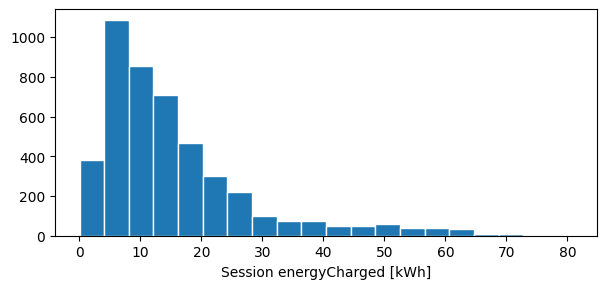

In [12]:
print(max(sessions['El_kWh']))
plt.figure(figsize=(7, 3))
plt.hist(sessions['El_kWh'], edgecolor='white', bins=20)
plt.xlabel('Session energyCharged [kWh]')
# plt.title('energyCharged distribution')
plt.show()

24.0


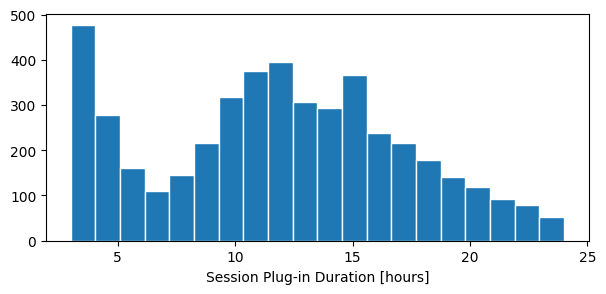

In [13]:
print(max(sessions['Duration_hours']))
plt.figure(figsize=(7, 3))
plt.hist(sessions[sessions['Duration_hours'] < 70]['Duration_hours'], edgecolor='white', bins=20)
plt.xlabel('Session Plug-in Duration [hours]')
plt.show()

0.0


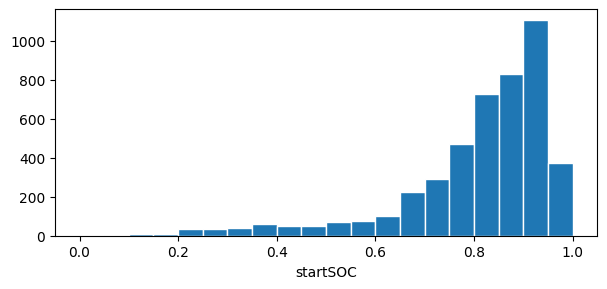

In [54]:
print(min(sessions['start_soc']))
plt.figure(figsize=(7, 3))
plt.hist(sessions['start_soc'], edgecolor='white', bins=20)
plt.xlabel('startSOC')
plt.show()

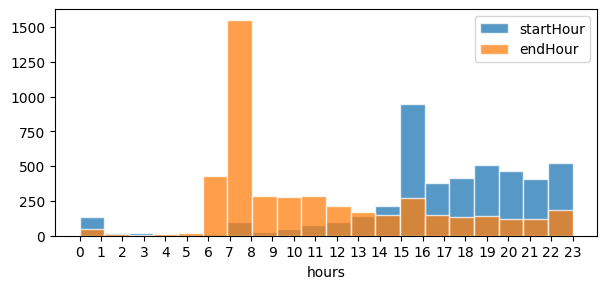

In [20]:
plt.figure(figsize=(7, 3))
plt.hist(sessions['Start_plugin_hour'], edgecolor='white', bins=20, alpha=0.75, label='startHour')
plt.hist(sessions['End_plugout_hour'], edgecolor='white', bins=20, alpha=0.75, label='endHour')
plt.legend()
plt.xlabel('hours')
plt.xticks(np.arange(24))
# plt.title('startHour vs. endHour')
plt.show()

In [55]:
sessions.to_csv('../data/sessions_12min.csv')

In [16]:
sessions.head()

,session_ID,Garage_ID,User_ID,User_type,Shared_ID,Start_plugin,Start_plugin_hour,End_plugout,End_plugout_hour,El_kWh,Duration_hours,month_plugin,weekdays_plugin,Plugin_category,Duration_category,end_soc,start_soc,start_day_idx,end_day_idx
2,3,AdO3,AdO3-4,Private,NaN,2018-12-21 11:33:00,11,2018-12-21 19:46:00,19.0,29.87,8.216667,Dec,Friday,late morning (9-12),Between 6 and 9 hours,1,0.631,69,118
3,4,AdO3,AdO3-2,Private,NaN,2018-12-22 16:15:00,16,2018-12-23 16:40:00,16.0,15.56,24.416667,Dec,Saturday,late afternoon (15-18),More than 18 hours,1,0.808,97,100
5,6,AdO3,AdO3-2,Private,NaN,2018-12-24 23:32:00,23,2018-12-25 17:37:00,17.0,16.14,18.083333,Dec,Monday,late evening (21-midnight),More than 18 hours,1,0.800,141,105
6,7,AdO3,AdO3-2,Private,NaN,2018-12-25 18:25:00,18,2018-12-26 16:08:00,16.0,10.33,21.716667,Dec,Tuesday,early evening (18-21),More than 18 hours,1,0.872,110,96
7,8,AdO3,AdO3-4,Private,NaN,2018-12-26 10:41:00,10,2018-12-26 16:52:00,16.0,27.66,6.183333,Dec,Wednesday,late morning (9-12),Between 6 and 9 hours,1,0.658,64,101


In [32]:
sessions[sessions['Duration_hours'] > 24].shape[0] / sessions.shape[0]

0.0

In [35]:
sessions['max_energyCharged'] = sessions['Duration_hours'] * 9.6

In [36]:
sessions[sessions['max_energyCharged'] < sessions['El_kWh']]

,session_ID,Garage_ID,User_ID,User_type,Shared_ID,Start_plugin,Start_plugin_hour,End_plugout,End_plugout_hour,El_kWh,Duration_hours,month_plugin,weekdays_plugin,Plugin_category,Duration_category,end_soc,start_soc,start_day_idx,end_day_idx,max_energyCharged
